In [7]:
from datetime import datetime
from iderare_pheno.converter import batchconvert
from iderare_pheno.simrec import hpo2omim_similarity, omim_recommendation, hpo2name, omim2name
from iderare_pheno.utils import linkage_dendrogram, list2tsv, generate_yml

In [8]:
def iderare_pheno_param(threshold=0.4, differential=10, recommendation=20, add_yml=False):
    # Your function logic here
    return threshold, differential, recommendation, add_yml

Processing clinical data :  SNOMEDCT:258211005
Trying to parse HPO from terminology SNOMEDCT:258211005
Parsing of SNOMEDCT:258211005 successful with result of : 1  HPO code :  HP:0000007 

SNOMEDCT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:36760000
Trying to parse HPO from terminology SNOMEDCT:36760000
Parsing of SNOMEDCT:36760000 successful with result of : 1  HPO code :  HP:0001433 

SNOMEDCT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:271737000
Trying to parse HPO from terminology SNOMEDCT:271737000
Parsing of SNOMEDCT:271737000 successful with result of : 1  HPO code :  HP:0001903 

SNOMEDCT is recognized as clinical finding, parsing to HPO and add to list
Processing clinical data :  SNOMEDCT:389026000
Trying to parse HPO from terminology SNOMEDCT:389026000
Parsing of SNOMEDCT:389026000 successful with result of : 1  HPO code :  HP:0001541 

SNOMEDCT is recognized

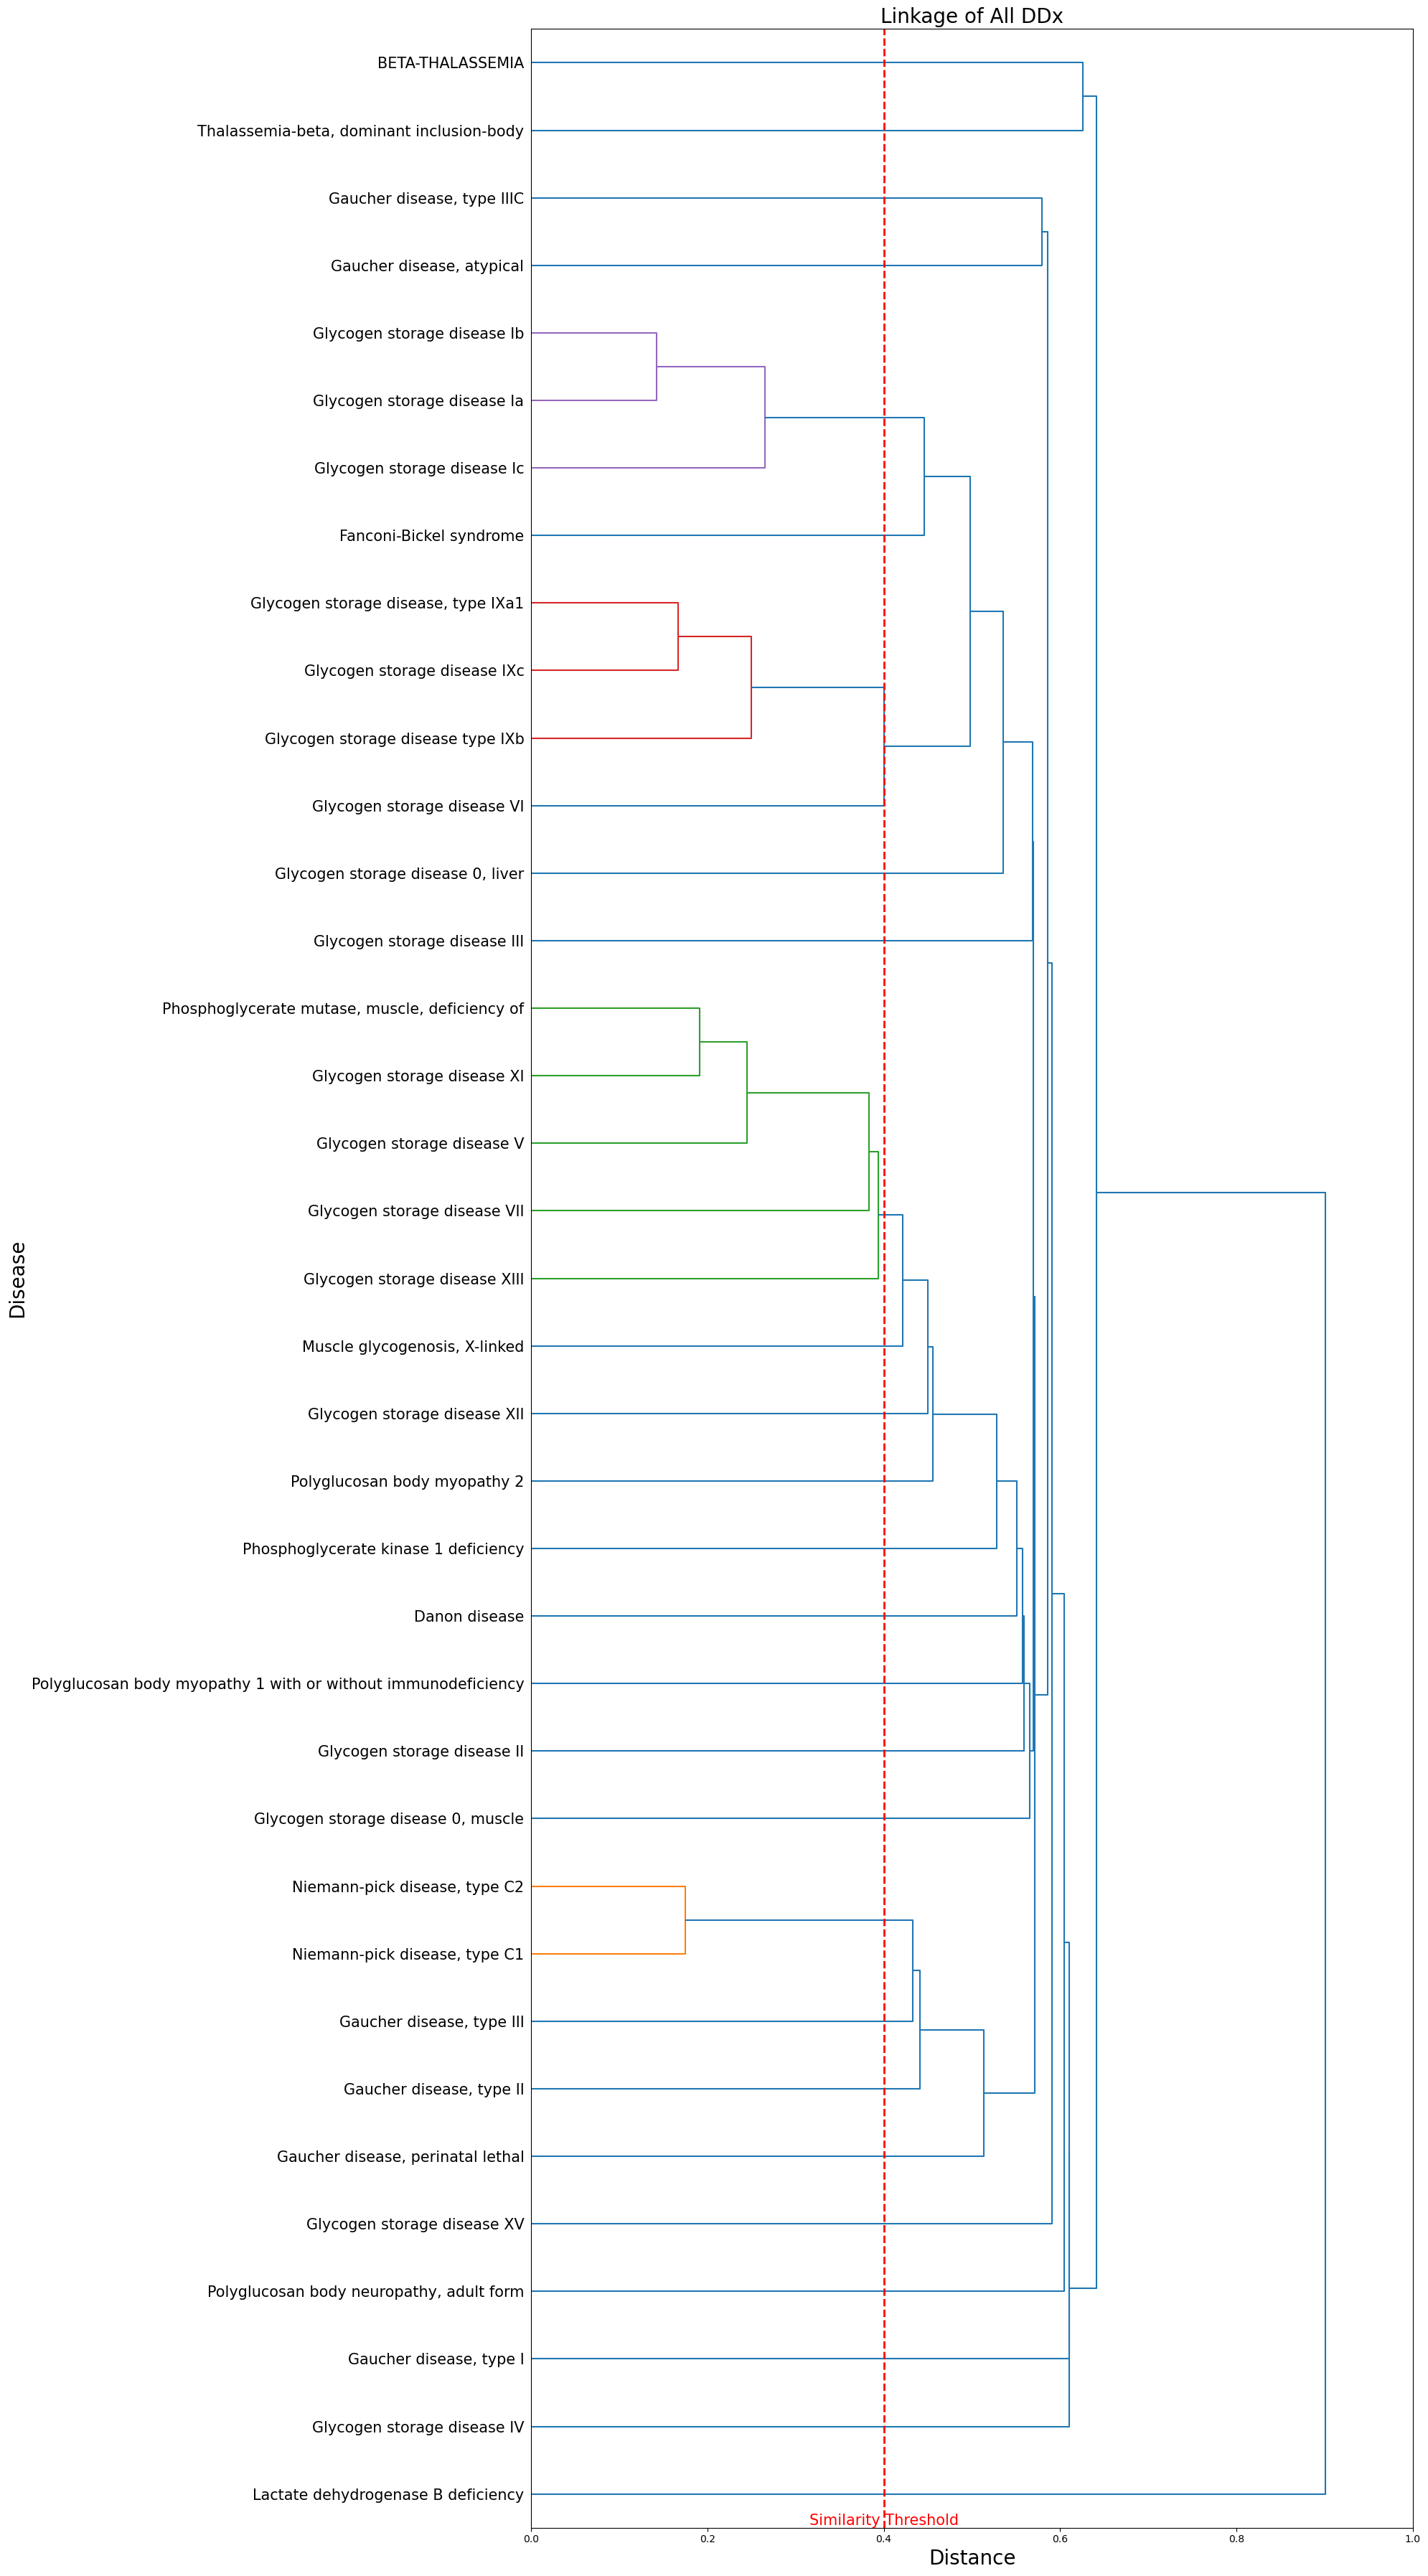

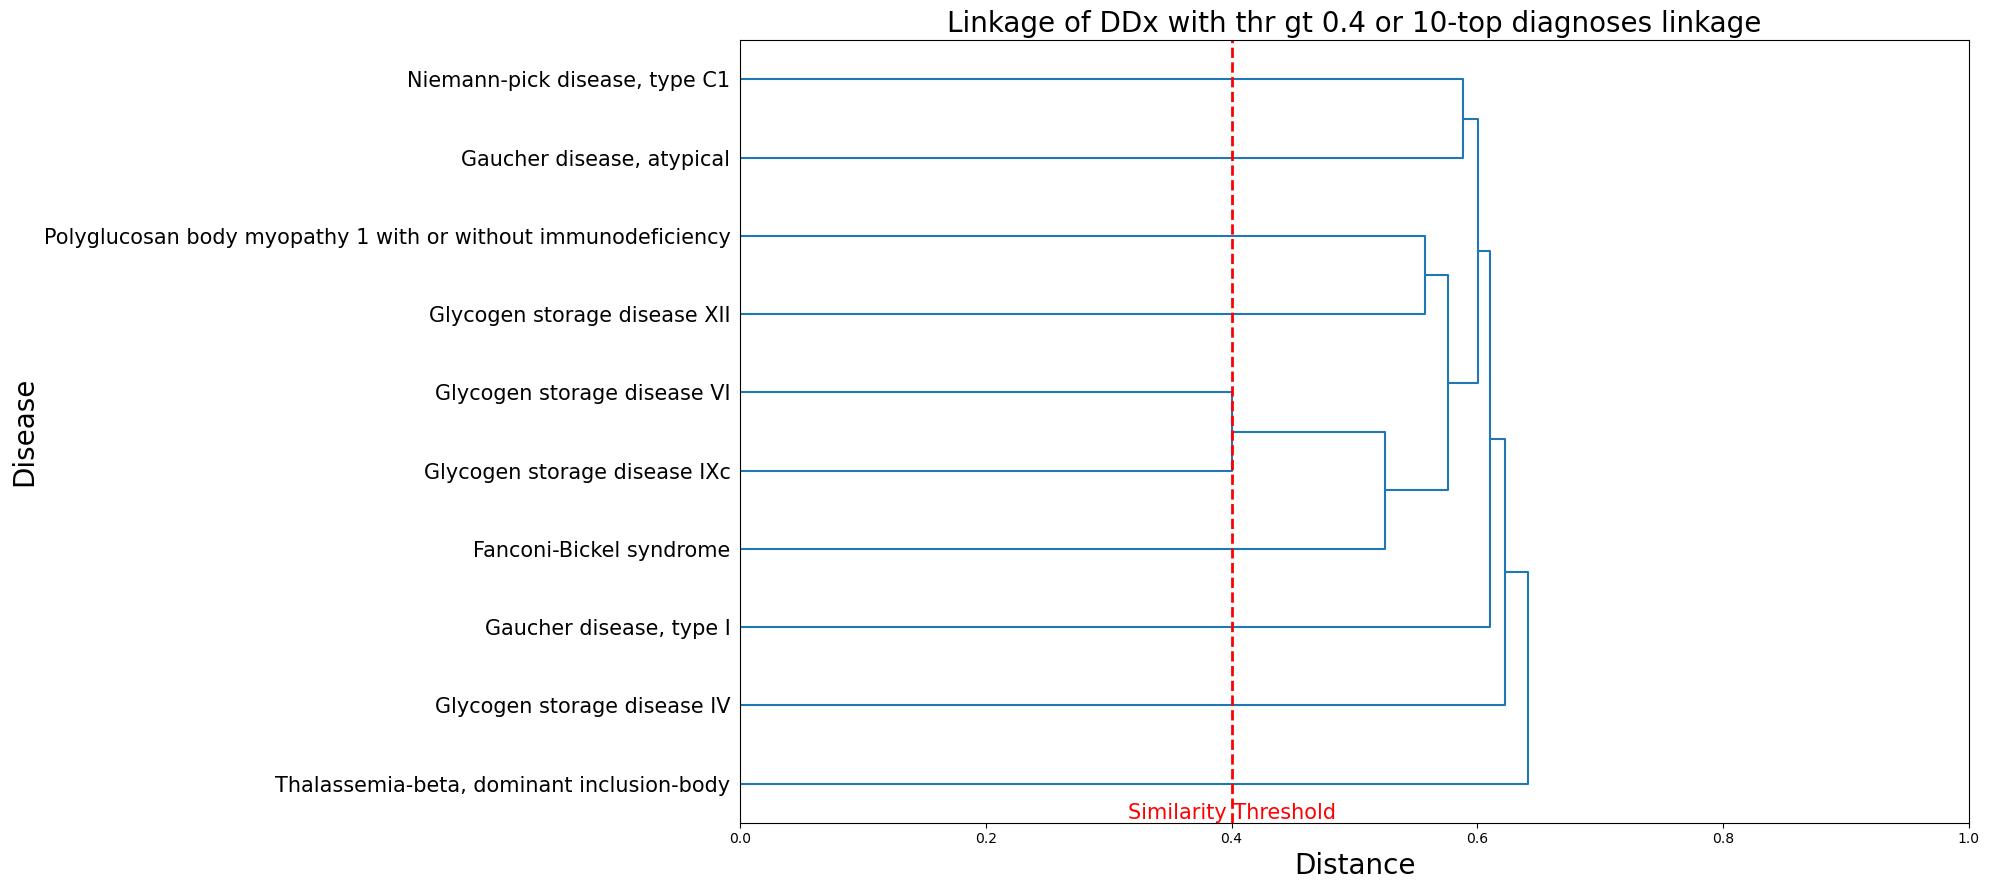

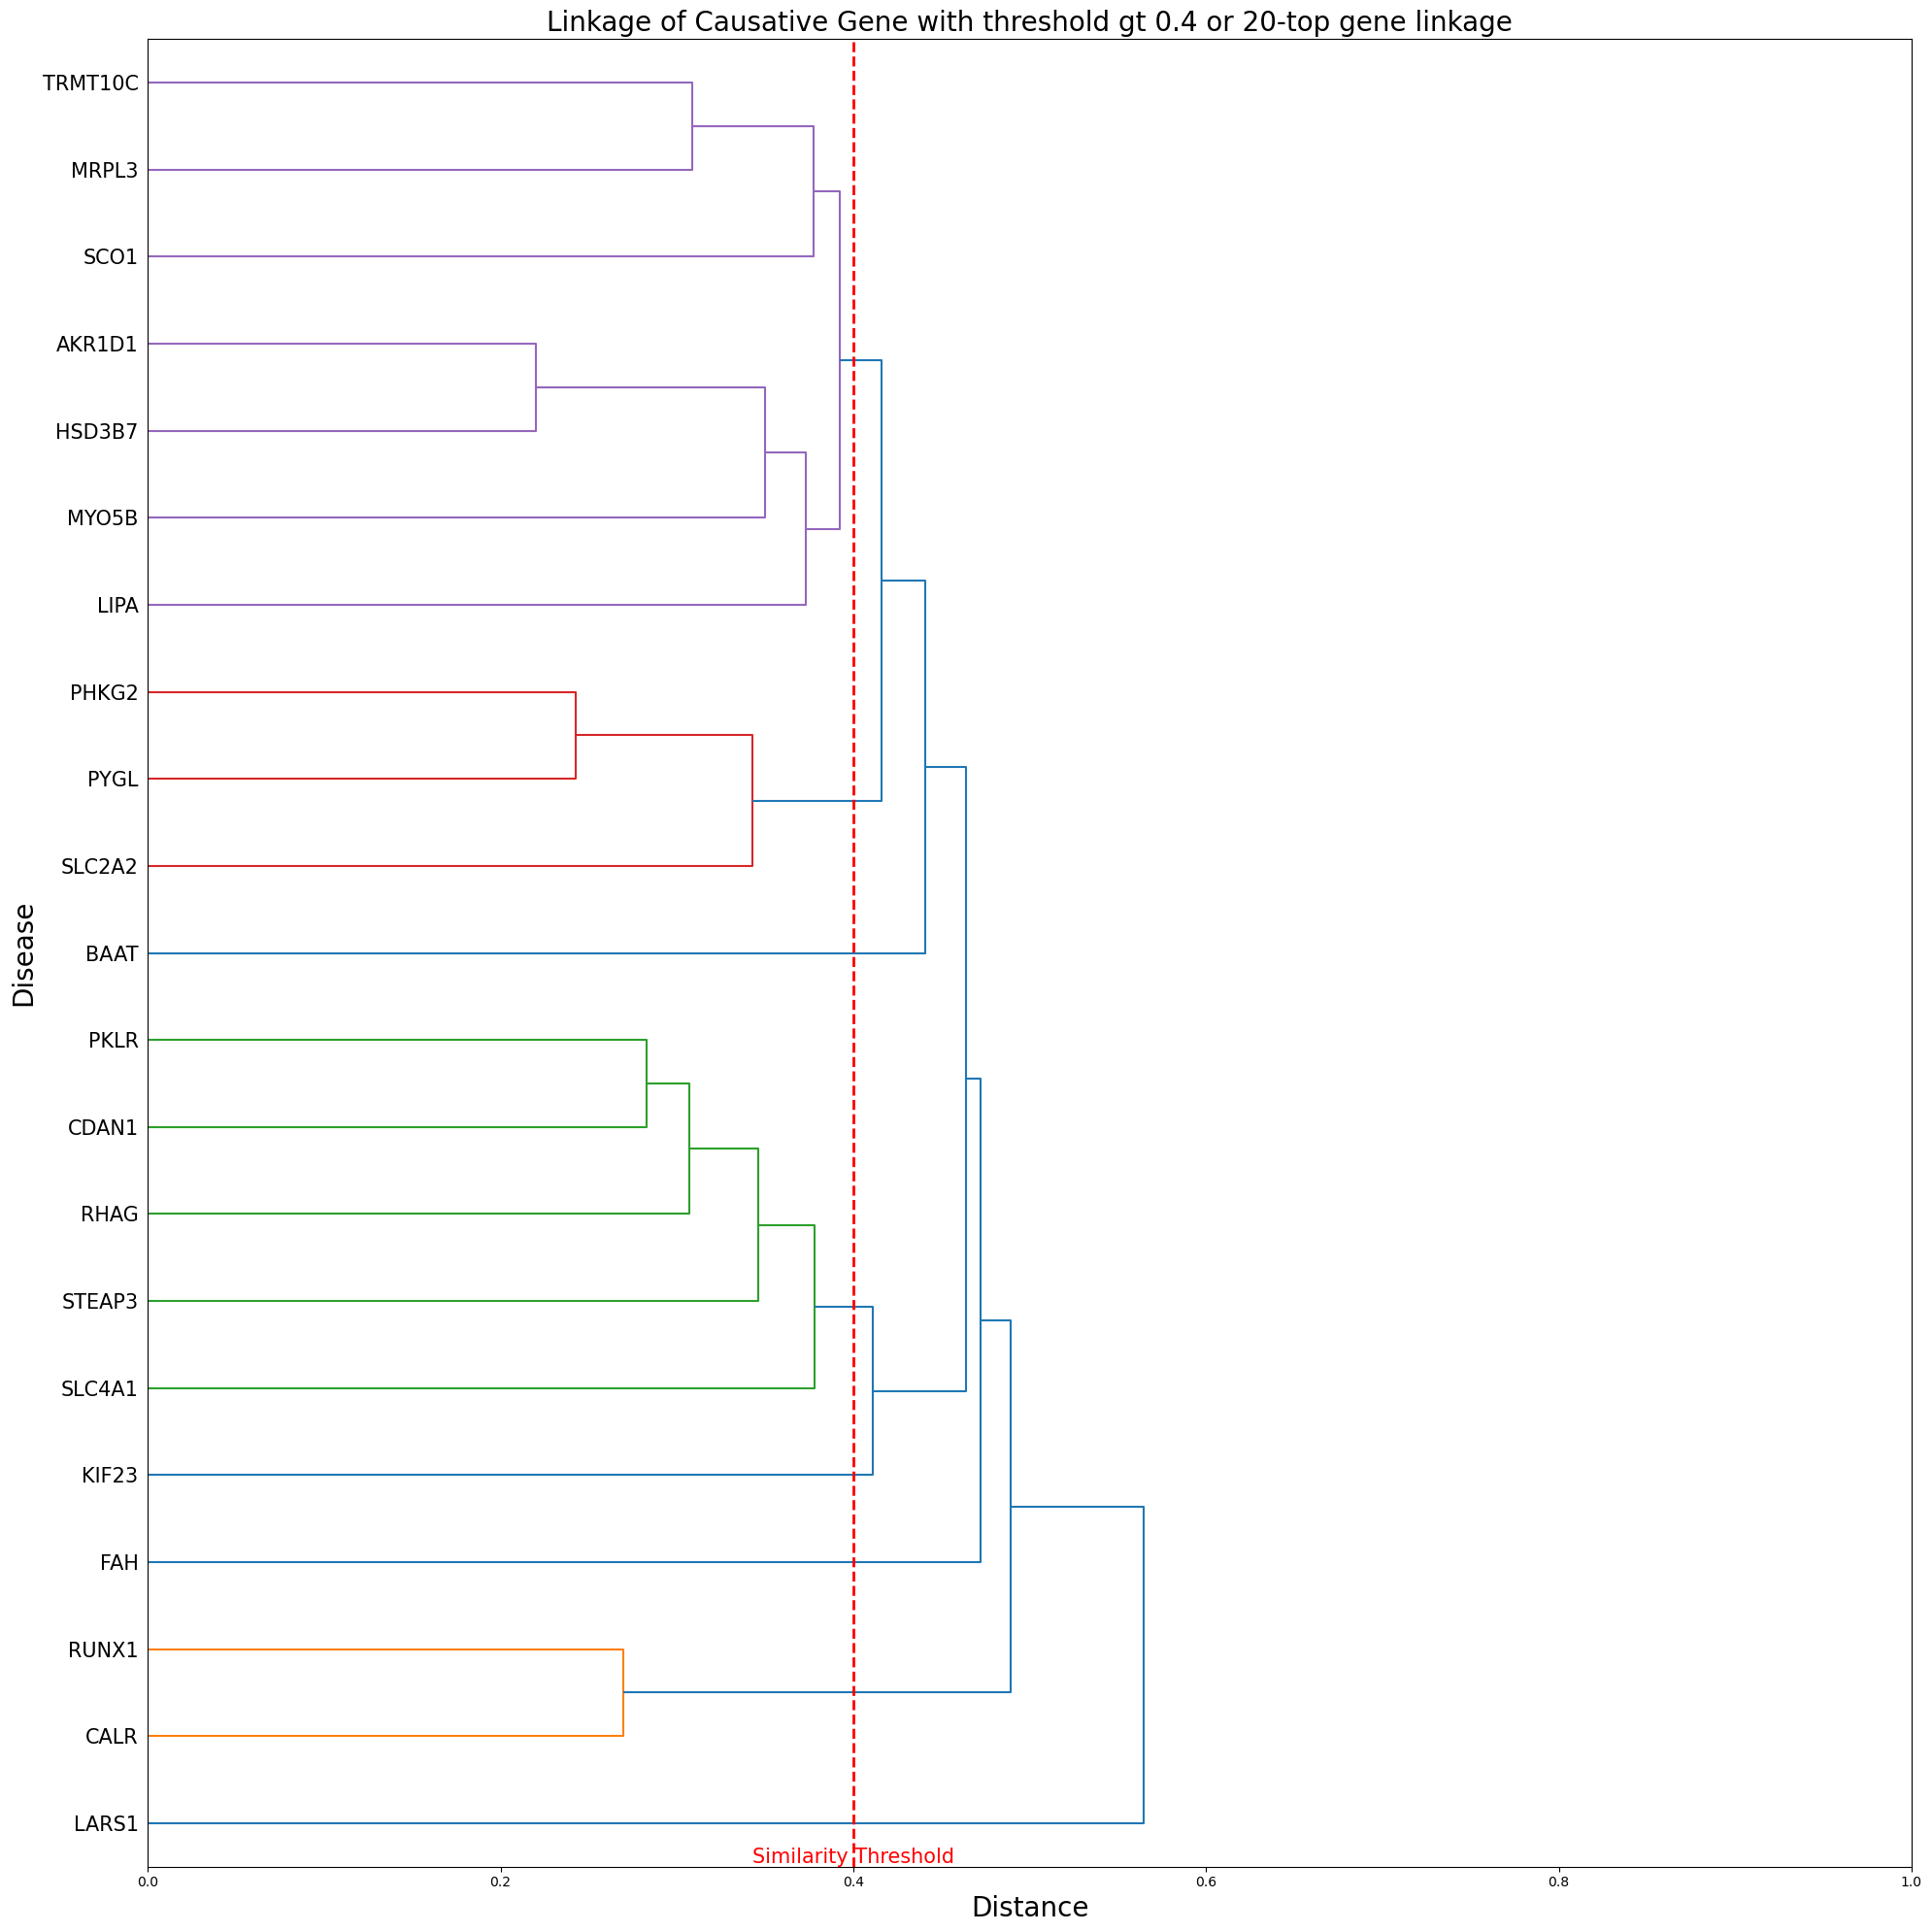

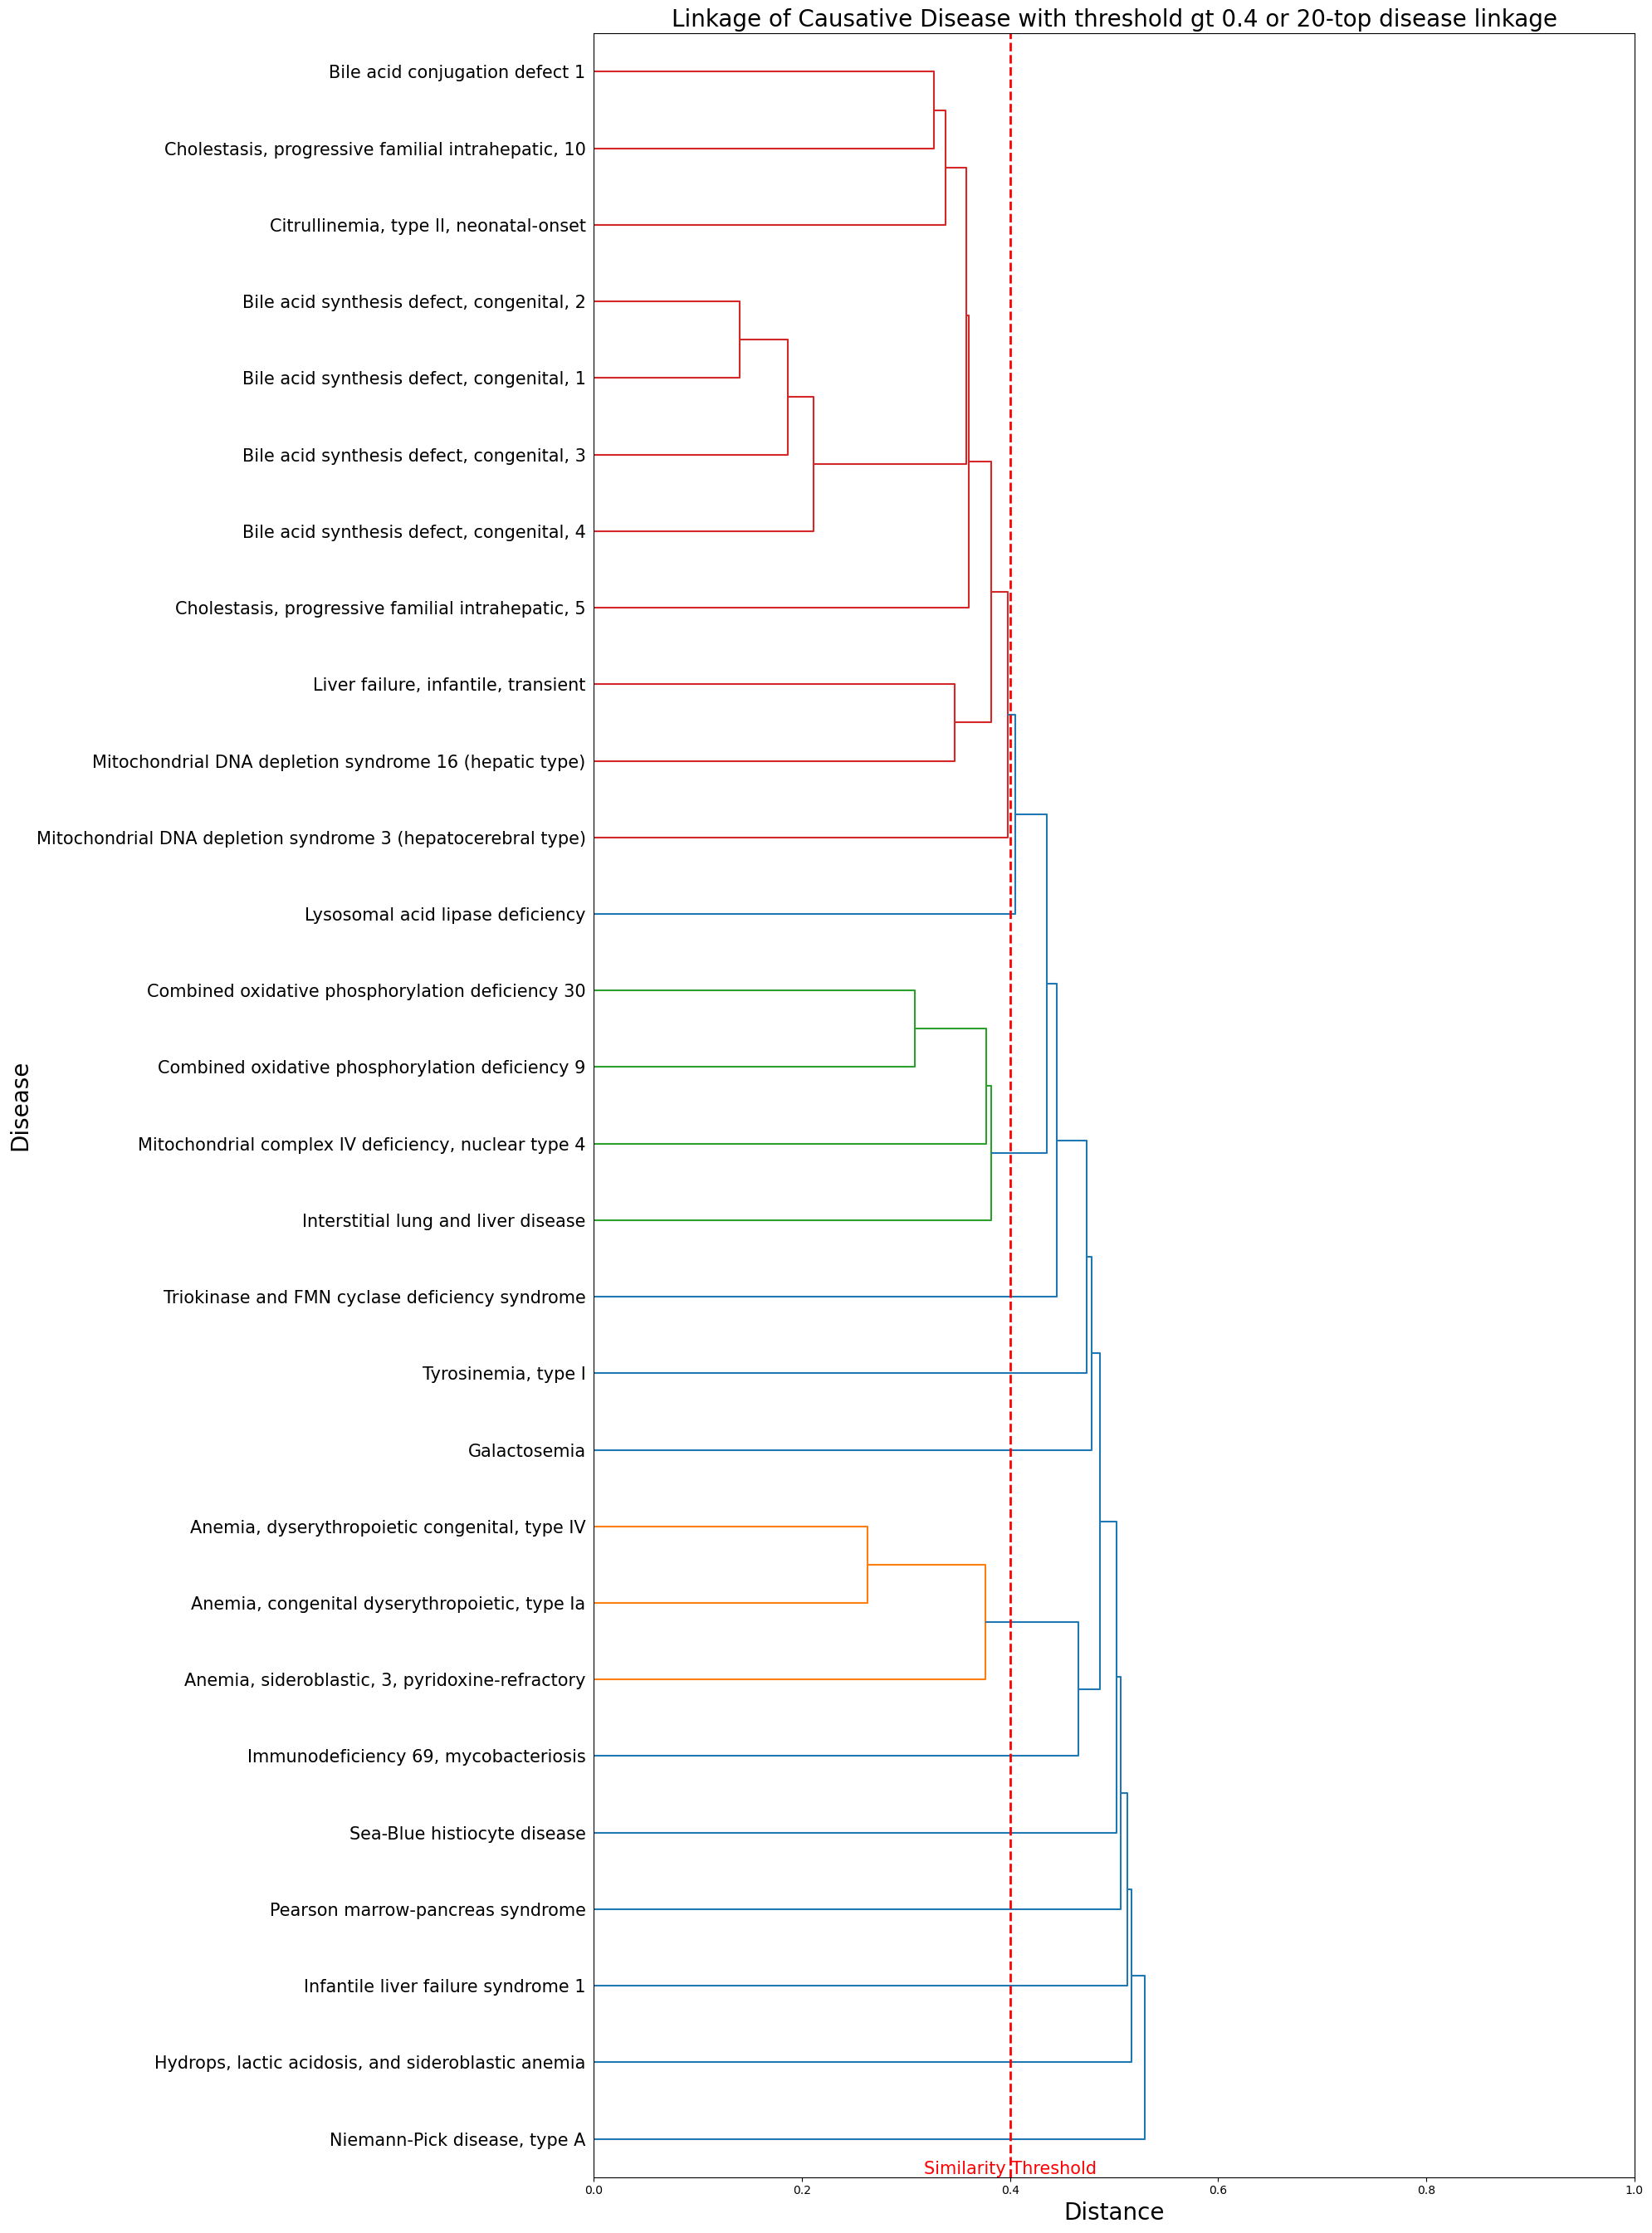

In [9]:
if __name__ == "__main__":
    # Clinical data dummy in txt format separated with new line
    clinical_data = 'clinical_data.txt'

    # Setup similarity threshold, number of n-top differential, and number of recommended alternative diagnoses 
    threshold, diffx, recx, add_yml = iderare_pheno_param(add_yml=True)

    # Read line from clinical_data and parse the data to list
    with open(clinical_data, 'r') as file:
        clinical_data_list = file.read().splitlines()

    # Split phenotype diagnosis split
    hpo_sets, diagnosis_sets = batchconvert(clinical_data_list)
    s_sim, [lnk_all, sr_dis_name, sr_dis_id], [lnk_thr, sr_dis_name_thr, sr_dis_id_thr] = hpo2omim_similarity(diagnosis_sets, hpo_sets, threshold=threshold, differential=diffx)

    # Plot all similarity in dendrogram threshold
    lnk_all_dendro = linkage_dendrogram(lnk_all, sr_dis_name, title='Linkage of All DDx', threshold=threshold, path_to_save='output/{}_linkage_all_ddx.png'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))
    lnk_thr_dendro = linkage_dendrogram(lnk_thr, sr_dis_name_thr, title='Linkage of DDx with thr gt ' + str(threshold) + ' or ' + str(diffx) + '-top diagnoses linkage', threshold=threshold, path_to_save='output/{}_linkage_filt_ddx.png'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))
    # Print the result with similarity > threshold
    for i in range(len(sr_dis_name_thr)):
        print('Rank', str(i+1), ':', sr_dis_name_thr[i], 'Sim:', s_sim[i])

    # Give recommendation of causative gene
    rg_s_sim,[ rg_lnk_all, rg_sr_dis_name, rg_sr_dis_id], [rg_lnk_thr, rg_sr_dis_name_thr, rg_sr_dis_id_thr] = omim_recommendation(hpo_sets, type='gene', threshold=threshold, recommendation=recx)
    lnk_thr_rg_dendo = linkage_dendrogram(rg_lnk_thr, rg_sr_dis_name_thr, title='Linkage of Causative Gene with threshold gt ' + str(threshold) + ' or ' + str(recx) + '-top gene linkage', threshold=threshold, path_to_save='output/{}_linkage_gene.png'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

    # Print the result with similarity > threshold
    print('Recommendation of high potential gene : ')
    for i in range(len(rg_sr_dis_name_thr)):
        print('Rank', str(i+1), ':', rg_sr_dis_name_thr[i], 'Sim:', rg_s_sim[i])

    # Give recommendation of causative disease
    rd_s_sim, [rd_lnk_all, rd_sr_dis_name, rd_sr_dis_id], [rd_lnk_thr, rd_sr_dis_name_thr, rd_sr_dis_id_thr] = omim_recommendation(hpo_sets, type='disease', threshold=threshold, recommendation=recx)
    lnk_thr_rd_dendo = linkage_dendrogram(rd_lnk_thr, rd_sr_dis_name_thr, title='Linkage of Causative Disease with threshold gt ' + str(threshold) + ' or ' + str(recx) + '-top disease linkage', threshold=threshold, path_to_save='output/{}_linkage_disease.png'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

    # Print the result with similarity > threshold
    print('Recommendation of high potential diagnoses : ')
    for i in range(len(rd_sr_dis_name_thr)):
        print('Rank', str(i+1), ':', rd_sr_dis_name_thr[i], 'Sim:', rd_s_sim[i])

    # Summary :
    ## Output of transformed_clinical_data.txt in List format, non enter separated
    print('---------')
    print('Finalizing the output')
    print('---------')

    # Save the output to text file
    print('There are total of {} HPO codes and {} OMIM codes parsed from the clinical data.'.format(len(hpo_sets), len(diagnosis_sets)))
    print('Save the HPO sets to list file.')
    with open('output/{}_transformed_hpo_set.txt'.format(datetime.now().strftime("%Y%m%d_%H%M%S")), 'w') as file:
        file.write(str(hpo_sets))

    hpo_name = hpo2name(hpo_sets)
    print('Save the HPO sets as tsv file.')
    list2tsv(hpo_sets, hpo_name, filename='output/{}_transformed_hpo_set'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

    omim_name = omim2name(diagnosis_sets)
    list2tsv(diagnosis_sets, omim_name, filename='output/{}_transformed_omim_set'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

    print('Saving differential diagnosis sets similarity result into tsv file.')
    list2tsv(sr_dis_id, sr_dis_name, s_sim, filename='output/{}_differential_diagnosis_similarity'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

    print('There are total of {} recommended genes and {} recommended diagnoses.'.format(len(rg_sr_dis_name_thr), len(rd_sr_dis_name_thr)))
    print('Saving gene and disease recommendation similarity result into tsv file.')
    list2tsv(rg_sr_dis_id, rg_sr_dis_name, rg_s_sim, filename='output/{}_recommended_gene_similarity'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))
    list2tsv(rd_sr_dis_id, rd_sr_dis_name, rd_s_sim, filename='output/{}_recommended_disease_similarity'.format(datetime.now().strftime("%Y%m%d_%H%M%S")))

    ## Generate iderare.yml file
    generate_yml(hpo_sets, filename='output/iderare.yml')